### Feature selection from EEG dataset, build and train a CNN

This code is designed to select features from EEG dataset, and train Convolution Neural Network to the new dataset

In [ ]:
from google.colab import drive
#mount the goole Drive files to Colab
drive.mount('/content/drive/')

#!ls drive/MyDrive/
import sys
import glob
sys.path.append('/content/drive/MyDrive/Thesis/')

PATH = "/content/drive/MyDrive/Thesis/model.pt"
FILES_PATH = glob.glob("/content/drive/MyDrive/eeg_dataset/filtered_data/*.mat")
LABELS_PATH = "/content/drive/MyDrive/eeg_dataset/scales.xls"
COORD_PATH = "/content/drive/MyDrive/eeg_dataset/Coordinates.xls"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#install the required packages
!pip install autoreject
!pip install mne
!pip install mne_features

In [ ]:
# - Basic imports

import mne
import matplotlib.pyplot as plt
import mne_features.univariate as mne_f
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import torch
import torch.optim as optim
import torch.nn as nn

from bsa import BSA
from mne_features.feature_extraction import extract_features
from poisson import poisson
from rockpool.nn.modules import LIF
from sklearn.model_selection import train_test_split
from sklearn import metrics
from torch.utils.data import DataLoader, ConcatDataset
from tqdm.autonotebook import tqdm, trange
from utils_old import EegData

sns.set(font_scale=1.2)

### Load dataset, split it in the tasks and create epochs

Each signal has 32 channels X 3200 samples = 25 sec of recording with 128 samples per second (SPS).
Spliting each signals in epochs of duration sec: 32 channels x   samples = duration sec x 128 SPS.
Number of epochs: 40 subjects X 12 trials X 5 epochs = 2400 epochs.

Final dataset: 2400 epochs X 32 channels X 640 samples

In [ ]:
# Read EEG data from the figshare dataset
print((FILES_PATH[0].split('/')))
#SOURCE_DIR = '/content/drive/My Drive/carseg_data/arrays'

arithmetic_task_files = [i for i in FILES_PATH if 'Arithmetic' in i.split('/')[6]]
mirror_image_task_files =[i for i in FILES_PATH if 'Mirror_image' in i.split('/')[6]]
relax_files = [i for i in FILES_PATH if 'Relax' in i.split('/')[6]]
stroop_task_files =  [i for i in FILES_PATH if 'Stroop' in i.split('/')[6]]

duration = 5
overlap = 3

arithmetic_task_epochs = [EegData.from_mat_file(i, len_segments = duration, overlap=overlap, data_key="Clean_data").data for i in arithmetic_task_files]
mirror_image_task_epochs = [EegData.from_mat_file(i, len_segments = duration, overlap=overlap, data_key="Clean_data").data for i in mirror_image_task_files]
relax_task_epochs = [EegData.from_mat_file(i, len_segments = duration, overlap=overlap, data_key="Clean_data").data for i in relax_files]
stroop_task_epochs = [EegData.from_mat_file(i, len_segments = duration, overlap=overlap, data_key="Clean_data").data for i in stroop_task_files]

data_list = arithmetic_task_epochs + mirror_image_task_epochs + relax_task_epochs + stroop_task_epochs
data_array = np.vstack(data_list)


['', 'content', 'drive', 'MyDrive', 'eeg_dataset', 'filtered_data', 'Arithmetic_sub_10_trial1.mat']
['/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_10_trial1.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_10_trial3.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_10_trial2.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_12_trial2.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_11_trial2.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_11_trial1.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_12_trial1.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_11_trial3.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_13_trial2.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_13_trial1.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_12_trial3.mat', '/conten

/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', '

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Th

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)
/content/drive/MyDrive/Thesis/utils_old.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


In [ ]:
print(data_array.shape)
no_repeat = data_array.shape[0]/(12*40)
# no_repeat = (25 - duration) / (duration - overlap) + 1 (if 25 % duration != 0 or overlap != 0)
print(no_repeat)
print(len(data_list))
print(len(arithmetic_task_epochs), len(mirror_image_task_epochs), len(relax_task_epochs), len(stroop_task_epochs))

(5280, 8, 640)
11.0
480
120 120 120 120


### Convert only one time signal in frequency domain

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_old.py:75: RuntimeWarning: Not setting positions of 32 misc channels found in montage:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_data.set_montage(montage)


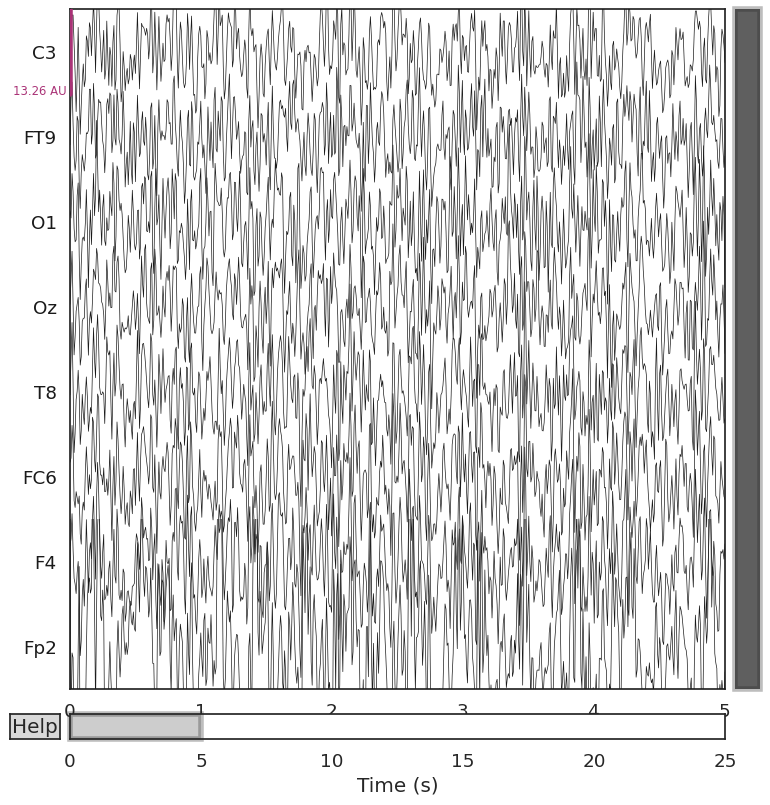

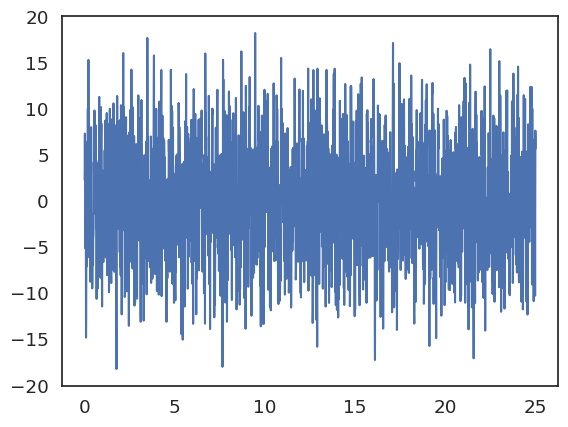

In [ ]:
raw = EegData.from_mat_file(arithmetic_task_files[30], data_key="Clean_data")._data

raw.plot(duration=5, n_channels=32)

sampling_freq = raw.info["sfreq"]
start_stop_seconds = np.array([0, 25])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 6
raw_selection = raw[channel_index, start_sample:stop_sample]
#print(raw_selection)

signal_x = raw_selection[1]
y = raw_selection[0].T
plt.plot(signal_x, y)

Filter the signal in frequency bands: theta waves (4–7 Hz), alpha waves (8–13Hz), beta waves (14–30 Hz) and gamma waves (31–50 Hz)

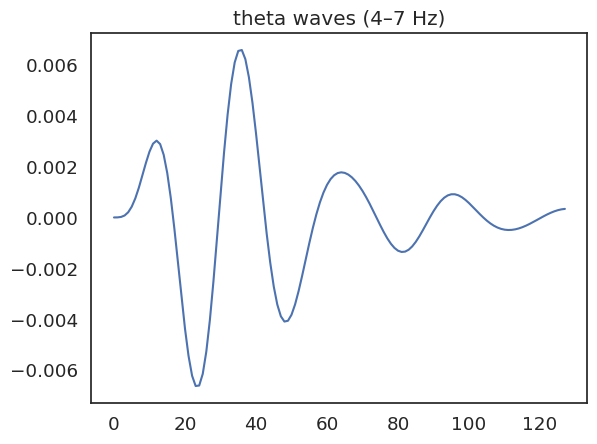

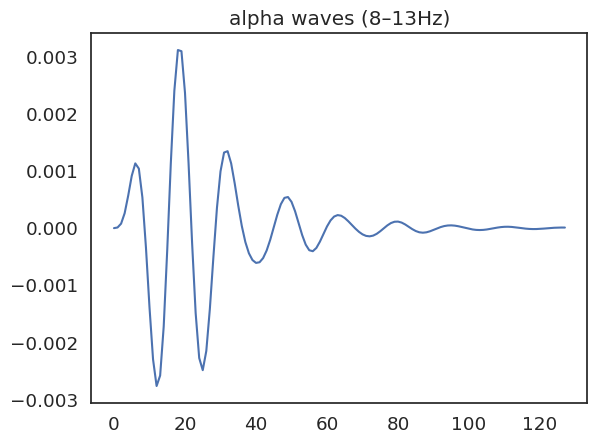

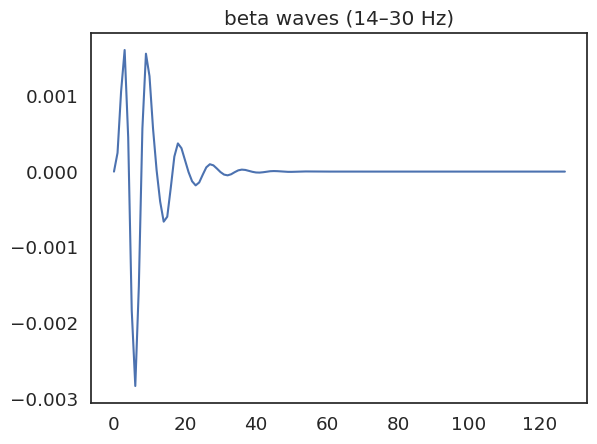

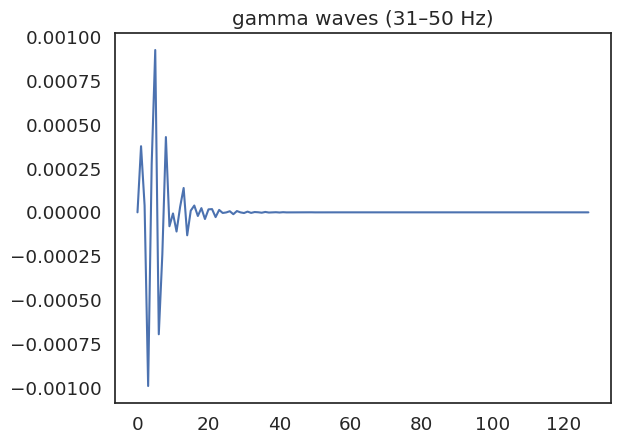

In [ ]:
import scipy.io
from scipy import signal, integrate
from scipy.signal import butter, lfilter

# Butterworth Bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# theta waves (4–7 Hz), alpha waves (8–13Hz), beta waves (14–30 Hz) and gamma waves (31–50 Hz)
x = butter_bandpass_filter(signal_x[:128], 4, 7, sampling_freq, order=3)
plt.title("theta waves (4–7 Hz)")
plt.plot(x)
plt.show()
y = butter_bandpass_filter(signal_x[:128], 8, 13, sampling_freq, order=3)
plt.title("alpha waves (8–13Hz)")
plt.plot(y)
plt.show()
y = butter_bandpass_filter(signal_x[:128], 14, 30, sampling_freq, order=3)
plt.title("beta waves (14–30 Hz)")
plt.plot(y)
plt.show()
y = butter_bandpass_filter(signal_x[:128], 31, 50, sampling_freq, order=3)
plt.title("gamma waves (31–50 Hz)")
plt.plot(y)
plt.show()

Compute the power spectral density

https://raphaelvallat.com/bandpower.html

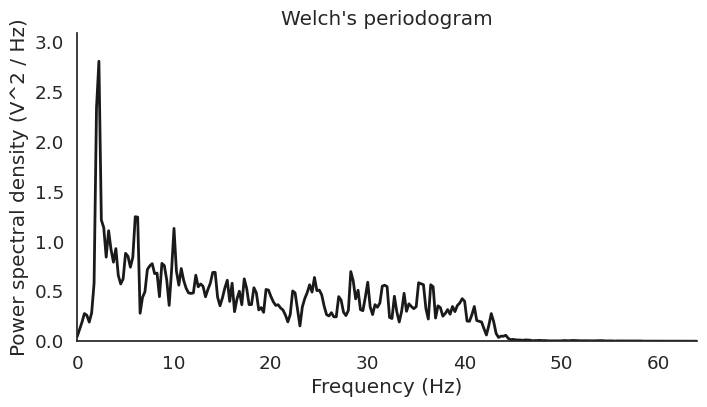

In [ ]:
from scipy import signal

# Define window length (4 seconds)
win = 4 * sampling_freq
one_channel = raw._data[0, :]
freqs, psd = signal.welch(one_channel, sampling_freq, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

In [ ]:
def eeg_power_band(epochs):

    # specific brainwave frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30],
                  "gamma": [30, 45],
                  }

    psds, freqs = signal.welch(epochs, picks='eeg', fmin=0.5, fmax=45) #compute PSD using the Welch method
    psds /= np.sum(psds, axis=-1, keepdims=True) #normalize the calculated PSDs

    X = [] #why this for loop? for each frequency band, we wanna compute the mean PSD in that band
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1) #<-- compute the mean PSD in each frequency band
        X.append(psds_band)

    return np.concatenate(X, axis=1) #concatenate the mean PSD for each band into a single feature vector

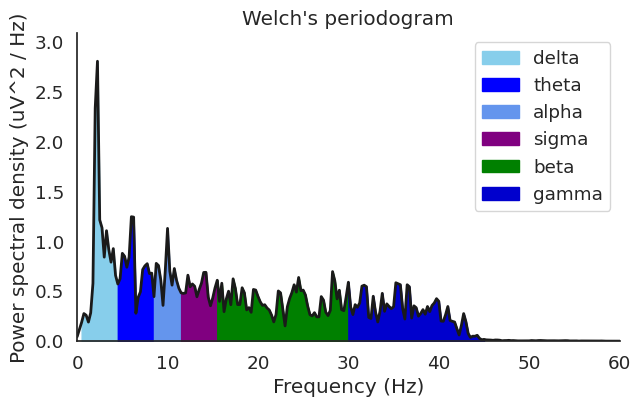

In [ ]:
# Define delta lower and upper limits
# specific brainwave frequency bands
FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30],
                  "gamma": [30, 45],
                  }
bands = ['delta', 'theta', 'alpha', 'sigma', 'beta', 'gamma']
colors = ['skyblue', 'blue', 'cornflowerblue', 'purple', 'green', 'mediumblue']
# Find intersecting values in frequency vector
idx = []
for band in bands:
  idx.append(np.logical_and(freqs >= FREQ_BANDS[band][0], freqs <= FREQ_BANDS[band][1]))

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
for i, color in enumerate(colors):
  plt.fill_between(freqs, psd, where=idx[i], label=bands[i], color=color)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 60])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.legend()
sns.despine()

##### Extract *'mean', 'ptp_amp', 'std', 'pow_freq_bands' and pow_freq_bands__freq_bands* features from initial dataset and create a new dataset

In [ ]:
freq_bands = np.array([0.5, 4, 8, 13, 30])
selected_funcs = {'mean', 'ptp_amp', 'std', 'pow_freq_bands'}
X_new = extract_features(data_array, raw.info['sfreq'], selected_funcs, {'pow_freq_bands__freq_bands': freq_bands})
#print(X_new[0])
print(X_new.shape, psd.shape)


(5280, 56) (257,)


### Load labels and match them with the data **samples**

40


array([[<Axes: title={'center': 'sub_'}>,
        <Axes: title={'center': 'Arithmetic_trial1'}>,
        <Axes: title={'center': 'Mirror_image_trial1'}>],
       [<Axes: title={'center': 'Stroop_trial1'}>,
        <Axes: title={'center': 'Arithmetic_trial2'}>,
        <Axes: title={'center': 'Mirror_image_trial2'}>],
       [<Axes: title={'center': 'Stroop_trial2'}>,
        <Axes: title={'center': 'Arithmetic_trial3'}>,
        <Axes: title={'center': 'Mirror_image_trial3'}>],
       [<Axes: title={'center': 'Stroop_trial3'}>, <Axes: >, <Axes: >]],
      dtype=object)

<Figure size 640x480 with 0 Axes>

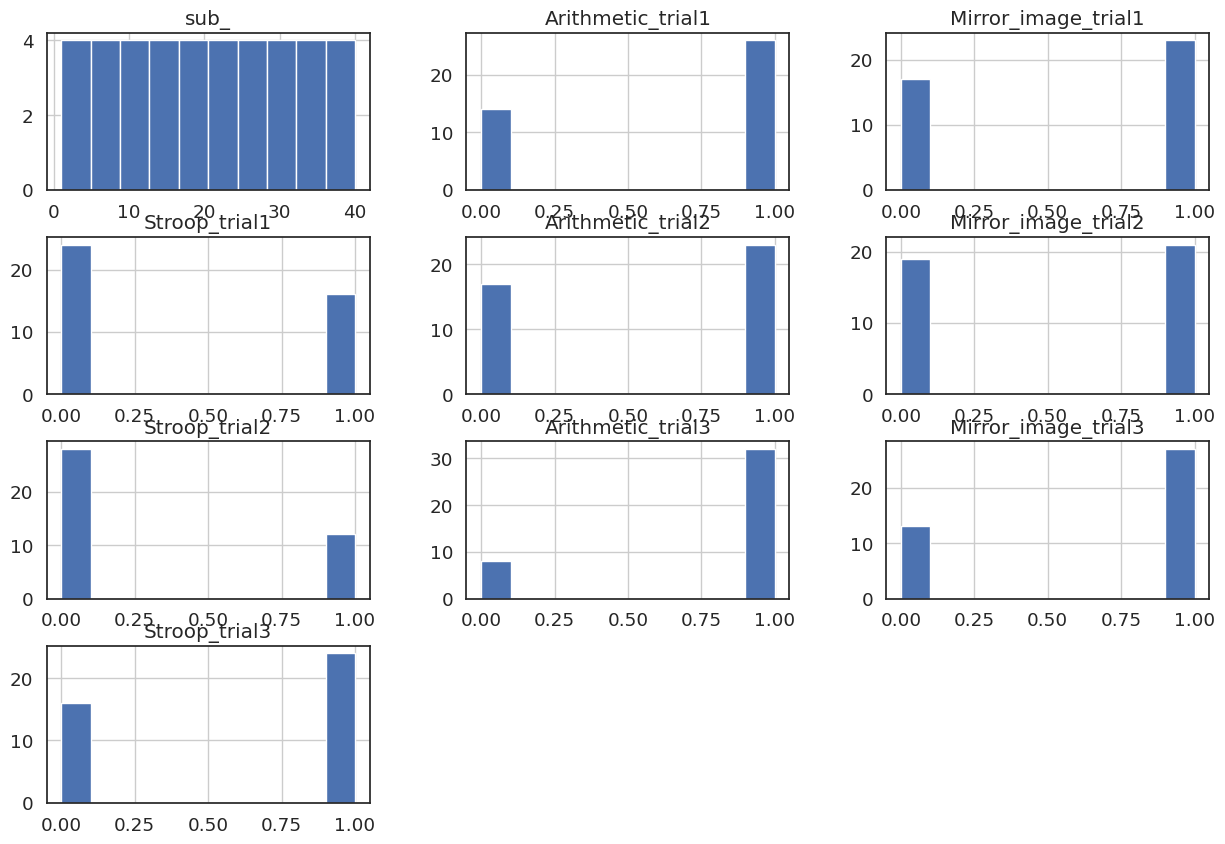

In [ ]:
# create labels: 0 - relaxed, 1 - stressed
COLUMNS_TO_RENAME = {
    'Subject No.': 'sub_',
    'Trial_1': 'Arithmetic_trial1',
    'Unnamed: 2': 'Mirror_image_trial1',
    'Unnamed: 3': 'Stroop_trial1',
    'Trial_2': 'Arithmetic_trial2',
    'Unnamed: 5': 'Mirror_image_trial2',
    'Unnamed: 6': 'Stroop_trial2',
    'Trial_3': 'Arithmetic_trial3',
    'Unnamed: 8': 'Mirror_image_trial3',
    'Unnamed: 9': 'Stroop_trial3'
}

def load_labels():
    '''
    Loads labels from the dataset and transforms the label values to binary values.

    Returns:
        ndarray: The labels.
    '''
    labels = pd.read_excel(LABELS_PATH)
    labels = labels.rename(columns=COLUMNS_TO_RENAME)
    labels = labels[1:]

    labels.iloc[:, 1:] = labels.iloc[:, 1:] >= 5
    labels = labels.astype("int")
    return labels

labels = load_labels()
print(len(labels))
plt.figure()
labels.hist(figsize=(15,10))

In [ ]:
def get_label(path_file):

    # extract only file name from the path_file
    file = os.path.basename(path_file)

    # remove .mat extension
    file = file.split('.')[0]

    # split the file into data frame columns
    split_file = file.split('_')

    # extract line and column from data frame
    line = int(split_file[len(split_file) - 2]) - 1

    # special case for Mirror_image
    if (len(split_file) == 5):
        split_file[0] = split_file[0] + '_' + split_file[1]
    column_name = split_file[0] + "_" + split_file[len(split_file) - 1]

    return labels.iloc[line][str(column_name)]

# extract labels for each task, subject and trial
arithmetic_task_labels = [get_label(i) for i in arithmetic_task_files]
relax_labels = [0 for i in relax_files]
stroop_task_labels =  [get_label(i) for i in stroop_task_files]
mirror_image_task_labels =[get_label(i) for i in mirror_image_task_files]

#repeat the labels for the specified amount of epochs
arithmetic_task_labels = np.array(arithmetic_task_labels).repeat(no_repeat)
relax_labels = np.array(relax_labels).repeat(no_repeat)
stroop_task_labels = np.array(stroop_task_labels).repeat(no_repeat)
mirror_image_task_labels = np.array(mirror_image_task_labels).repeat(no_repeat)

label_array = np.concatenate((arithmetic_task_labels, relax_labels, stroop_task_labels, mirror_image_task_labels))
print(label_array.shape)

(5280,)


Split dataset in train set, validation set and testing set

In [ ]:
# - Create a data loader for the training dataset
x, x_test, y, y_test = train_test_split(X_new, label_array, test_size=0.3, shuffle=True, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.20, random_state=1)

x_train = torch.from_numpy(np.expand_dims(x_train, axis=1))
x_val = torch.from_numpy(np.expand_dims(x_val, axis=1))
x_test = torch.from_numpy(np.expand_dims(x_test, axis=1))
# Create dataloaders
train_batch_size = 16  # Important hyperparameter
valid_batch_size = 16  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

print(x_train[0].shape)

loader_train = DataLoader(
    list(zip(x_train,y_train)), batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
loader_valid = DataLoader(
    list(zip(x_val,y_val)), batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(
    list(zip(x_test,y_test)), batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)

torch.Size([1, 56])


Define the model, training and test it

In [ ]:
def plot_acc_and_loss(history, figsize=(10,4)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    ax1.title.set_text("Acc")
    ax1.set_xlabel("Epochs")
    l1 = ax1.plot(history["acc"], color="red", label='train')
    l2 = ax1.plot(history["val_acc"], color="blue", label='test')

    ax2.title.set_text("Loss")
    ax2.set_ylabel("Epochs")
    l3 = ax2.plot(history["loss"], color="red", label='train')
    l4 = ax2.plot(history["val_loss"], color="blue", label='test')

    ax1.legend(loc="upper right")
    ax2.legend(loc="upper right")

    plt.show()

In [ ]:
class Model(object):
    def __init__(self, model=None, lr=0.001):
        super(Model, self).__init__()
        self.model = model
        self.losses = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=lr)

    def fit(self, trainloader=None, validloader=None, epochs=1, monitor=None, only_print_finish_ep_num=False):
        doValid = False if validloader == None else True
        pre_ck_point = [float("inf"), 0.0, float("inf"), 0.0, 0] # loss, acc, val_loss, val_acc, epoch
        history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}
        print('epoch \t train_loss \t val_loss \t train_acc \t val_acc')
        print('-------------------------------------------------------------------')
        for ep in range(1, epochs + 1):
            proc_start = time.time() # timer start
            if (not (ep % 10)):
                if not only_print_finish_ep_num:
                    print(f"Epoch {ep}/{epochs}")
                    print(f'{ep} \t {loss:0.4f} \t {val_loss:0.4f}  \t {acc:0.4f} \t {val_acc:0.4f} \t ')
            self.model.train()       # Train mode
            step = 1                 # Restart step
            for x_batch, y_batch in trainloader:
                x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)

                pred = self.model(x_batch)
                y_batch = y_batch.long()
                y_batch.view(len(y_batch), 1)
               # print("Pred, x_batch and y_batch for loses", pred.shape, x_batch.shape, y_batch.shape)
                loss = self.losses(pred, y_batch)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                if (not (ep % 10)) or (ep == 1):
                    pbar = int(step * 30 / len(trainloader))
                    if not only_print_finish_ep_num:

                        print("\r{}/{} [{}{}]".format(
                            step, len(trainloader), ">" * pbar, " " * (30 - pbar)), end="")
                    step += 1
            loss, acc = self.evaluate(trainloader)   # Loss & Accuracy
            val_loss, val_acc = self.evaluate(validloader) if doValid else (0, 0)   # if have validation dataset, evaluate validation
            history["loss"] = np.append(history["loss"], loss)
            history["acc"] = np.append(history["acc"], acc)
            history["val_loss"] = np.append(history["val_loss"], val_loss)
            history["val_acc"] = np.append(history["val_acc"], val_acc)
            # Update checkpoint
            if self.__updateCheckpoint(monitor, pre_ck_point, [loss, acc, val_loss, val_acc, ep]):
                save_file_name = f"checkpoint_model_ep-{ep}.pt"
                self.save(save_file_name)
                pre_ck_point = [loss, acc, val_loss, val_acc, ep]
                history['lastest_model_path'] = save_file_name

            if only_print_finish_ep_num and (ep % 50 == 0):
                print(f'{ep} \t {loss:0.4f} \t {val_loss:0.4f}  \t {acc:0.4f} \t {val_acc:0.4f} \t ')
        return history

    def evaluate(self, dataloader):
        total, acc = 0, 0
        self.model.eval()           # Eval mode
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
            pred = self.model(x_batch)
            loss = self.losses(pred, y_batch).item()
            total += y_batch.shape[0]     # Number of data
            acc += (torch.sum(pred.argmax(dim=1)==y_batch)).item()     # Sum the prediction that's correct
        acc /= total     # Accuracy = correct prediction / number of data
        return (loss, acc)

    def predict(self, dataset):
          dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)
          prediction = []
          truth = []
          self.model.eval()
          for x_batch, y_batch in dataloader:
              x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
              pred = self.model(x_batch).cpu()
              prediction = np.append(prediction, pred.argmax(dim=1).numpy())
              truth = np.append(truth, y_batch.cpu().numpy())
          return prediction, truth

    def save(self, filepath):
          torch.save(self.model, filepath)

    def load(cls, filepath):
        return cls(torch.load(filepath))

    def __updateCheckpoint(self, monitor, pre_ck_point, evaluation):
        if type(monitor) is int:
            return True if evaluation[4] % monitor == 0 else False
        elif type(monitor) is list:
            for _ in monitor:
                if not _ in ["loss", "acc", "val_loss", "val_acc"]:
                    raise Exception(f"\"{_}\" is not a valid monitor condition.")
                elif _ == "loss" and pre_ck_point[0] <= evaluation[0]:
                    return False # present epoch loss > history loss
                elif _ == "acc" and pre_ck_point[1] >= evaluation[1]:
                    return False # present epoch acc <= history acc
                elif _ == "val_loss" and pre_ck_point[2] <= evaluation[2]:
                    return False # present epoch val_loss > history val_loss
                elif _ == "val_acc" and pre_ck_point[3] >= evaluation[3]:
                    return False # present epoch val_acc < history val_acc
        return True

In [ ]:
# - Determine which advice to use for training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(device)
Learning_Rate = 0.0007
EPOCHS = 1000

# create model
cnn = nn.Sequential(
    nn.Conv1d(1, 16,  5, padding = 1, bias=False),
    nn.BatchNorm1d(16),
    nn.ReLU(),

    nn.Conv1d(16, 32,  5, padding = 1, bias=False),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(32, 32, 5, padding=1, bias=False),
    nn.Conv1d(32, 32, 5, padding=1, bias=False),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Flatten(),
    nn.Linear(352, 2),
)

model = Model(cnn, lr=Learning_Rate)

print(cnn)

cpu
Sequential(
  (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(1,), bias=False)
  (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(1,), bias=False)
  (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(1,), bias=False)
  (9): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(1,), bias=False)
  (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Dropout(p=0.5, inplace=False)
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): Linear(in_features=352, out_features=2, bias=True)
)


In [ ]:
history = model.fit(trainloader=loader_train, validloader=loader_valid, epochs=EPOCHS, monitor=["acc", "val_acc"])

epoch 	 train_loss 	 val_loss 	 train_acc 	 val_acc
-------------------------------------------------------------------
185/185 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 10/1000
10 	 0.6987 	 0.6139  	 0.5853 	 0.5500 	 
185/185 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 20/1000
20 	 0.5810 	 0.5997  	 0.6211 	 0.5689 	 
185/185 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 30/1000
30 	 0.7234 	 0.3123  	 0.6580 	 0.6095 	 
185/185 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 40/1000
40 	 0.7348 	 0.2907  	 0.7030 	 0.6284 	 
185/185 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 50/1000
50 	 0.5193 	 0.3015  	 0.7253 	 0.6311 	 
185/185 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 60/1000
60 	 0.4708 	 0.3667  	 0.7216 	 0.6446 	 
185/185 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 70/1000
70 	 0.3737 	 0.1993  	 0.7341 	 0.6649 	 
185/185 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 80/1000
80 	 0.4920 	 0.3106  	 0.7368 	 0.6473 	 
185/185 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 90/1000
90 	 0.5139 	 0.3745  	 0.7520 	 0.6716 	 
185/185

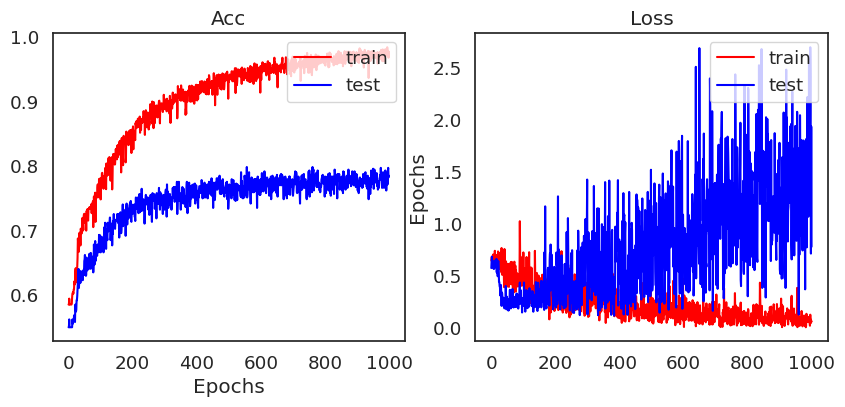

In [ ]:
plot_acc_and_loss(history=history)

In [ ]:
print(f"Max valid accuracy is:", max(history['val_acc']))
print(f"Avg valid accuracy is:", sum(history['val_acc'])/len(history['val_acc']))

Max valid accuracy is: 0.7986486486486486
Avg valid accuracy is: 0.7460999999999978


In [ ]:
loss, acc = model.evaluate(loader_test)

print(f"Test loss is:", loss)
print(f"Test accuracy is", acc)

Test loss is: 0.42082178592681885
Test accuracy is 0.8371212121212122
